# ANALISIS DATA COVID-19 COLOMBIA

Xibelly Eliseth Mosquera Escobar

##  Importación de paquetes, librerias y funciones

In [1]:
import math
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta
from time import time
from functools import reduce
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
#import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score

from sklearn.base import TransformerMixin
#from yellowbrick.classifier import DiscriminationThreshold
import regex as re
import unicodedata
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import regexp_tokenize
from collections import OrderedDict

In [3]:
def ETL (file):
    print('-'*65)
    print('se realiza la carga de la base de datos a un objeto data frame')
    df= file #pd.read_table(file)  #pd.read_pickle(Direccion + nombreBd)
    print("RevisiÃ³n de los datos(NÃºmero de Variables, NÃºmero de registros)")
    print('NÃºmero de variables: {0}'.format(df.shape[1]))
    print('NÃºmero de registros: {0}'.format(df.shape[0]))
    print('-'*65)
    print("revisiÃ³n de las variables que posee la base de datos ")
    print(list(df.columns.values))
    print('-'*65)
    print("Resumen descriptivo de las variables ")
    print(df.describe())
    print('-'*65)
    print('Revision del tipo de variables que contiene la base de datos')
    print(pd.DataFrame(df.dtypes,columns=['Tipo de variable']))
    print('-'*65)
    print("Se realiza una revisiÃ³n si existen datos N/A")
    revisionNull(df)
    print('-'*65)
    print('SelecciÃ³n de variables, en este paso lo que se realiza es la organizaciÃ³n de las variables, para trabajar con las variables categoricas a parte y las numericas ')
    var_categoricas = list(df.select_dtypes(include=['object']).columns)
    var_numericas = list(df.select_dtypes(exclude=['object']).columns)
    print('-'*65)
    print('Reporte de los niveles que puede tener cada una de las variables categoricas')
    for variable in var_categoricas:
        print("\033[1m",variable,":","\033[0;0m",df[variable].unique())
    print(80*'-')
    for variabl in  var_numericas:
        print("--"*30,variabl)
        #plt.cla()
        x = df[variabl].sort_values(ascending = False).reset_index()
        x[variabl].plot()
        #plt.plot(df[variabl].sort_values())    
        plt.show()
        plt.boxplot(x[variabl])
        plt.show()
        plt.close()

    
def revisionNull(df):
    a=df.isnull().sum()
    resulNa=[ re for re in a if re>0 ]
    if resulNa:
        print(resulNa)
        
    else :
        print("No existen valores con NA o null")
                

In [4]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].min() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [5]:
def normalizando_la_data(df):

    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import StandardScaler

    #customer id col
    Id_user  = ['ID']
    #Target columns
    target_col   = ["Estado"]
    #date
    user_date = ['Fecha de diagnóstico']
    #categorical columns
    cat_cols     = list(df.select_dtypes(include=['object']).columns)
    cat_cols     = [x for x in cat_cols if x not in target_col + Id_user + user_date]
    #numerical columns
    num_cols     = [x for x in df.columns if x not in cat_cols + target_col + Id_user + user_date]


    #Binary columns with 2 values
    bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
    multi_cols = [i for i in cat_cols if i not in bin_cols]

    #Label encoding Binary columns
    le = LabelEncoder()
    for i in bin_cols :
        df[i] = le.fit_transform(df[i])

    #Duplicating columns for multi value columns
    df = pd.get_dummies(df,columns = multi_cols )

    #Scaling Numerical columns
    std = StandardScaler()
    scaled = std.fit_transform(df[num_cols])
    scaled = pd.DataFrame(scaled,columns=num_cols)

    #dropping original values merging scaled values for numerical columns
    #df_telcom_og = Vista_unica.copy()
    df = df.drop(columns = num_cols,axis = 1)
    df = df.merge(scaled,left_index=True,right_index=True,how = "left") 

    return df

In [6]:
def correlacion(df):
    #correlation
    correlation = df.corr()

    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)

    #Plotting
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale = "Viridis",
                       colorbar   = dict(title = "Pearson Correlation coefficient",
                                         titleside = "right"
                                        ) ,
                      )

    layout = go.Layout(dict(title = "Correlation Matrix for variables",
                            autosize = False,
                            height  = 720,
                            width   = 800,
                            margin  = dict(r = 0 ,l = 210,
                                           t = 25,b = 210,
                                          ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9))
                           )
                      )

    data_plot = [trace]
    fig = go.Figure(data=data_plot,layout=layout)
    py.iplot(fig)

In [7]:
def procesar_texto(texto): 
    # Convert to lower case and remove punctuation from each word
    sentences = ''.join([word.lower() for word in texto if word.isalpha()])
    return sentences


def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)


##   Lectura de los insumos

In [8]:
dir_input = r"C:\Users\Usuario\Documents\Xibelly\covid-19\Input"

file= os.listdir(dir_input)


print("los archivos suministrados son: ")
print("covid-19 colombia ", file, "\n")

los archivos suministrados son: 
covid-19 colombia  ['Casos1.csv'] 



In [9]:
#leyendo los archivos de  "ESTADO" y concatenando en un solo dataframe
archivo = pd.read_csv(os.path.join(dir_input,'Casos1.csv'), sep=',', error_bad_lines=False, encoding='utf-8')

archivo.head()

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento o Distrito,Atención**,Edad,Sexo,Tipo*,País de procedencia
0,1,06/03/2020,Bogotá,Bogotá D.C.,Recuperado,19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle del Cauca,Recuperado,34,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50,F,Importado,España
3,4,11/03/2020,Medellín,Antioquia,Recuperado,55,M,Relacionado,Colombia
4,5,11/03/2020,Medellín,Antioquia,Recuperado,25,M,Relacionado,Colombia


In [10]:
archivo.dtypes

ID de caso                  int64
Fecha de diagnóstico       object
Ciudad de ubicación        object
Departamento o Distrito    object
Atención**                 object
Edad                        int64
Sexo                       object
Tipo*                      object
País de procedencia        object
dtype: object

In [11]:
# renombrando las columnas
archivo = archivo.rename(columns={'Atención**':'Estado', 'Tipo*':'Tipo', 'ID de caso':'ID', 'Ciudad de ubicación':'Ciudad_destino', 'País de procedencia':'Pais_origen'})
archivo = archivo.drop(['Departamento o Distrito'], axis=1)
archivo = archivo.drop(['Sexo'], axis=1)

In [12]:
# convirtiendo las fechas en formato date-time
archivo["Fecha de diagnóstico"] = archivo["Fecha de diagnóstico"].replace('/','',regex=True).astype(str)
archivo["Fecha de diagnóstico"] = pd.to_datetime(archivo["Fecha de diagnóstico"], format='%d%m%Y')
archivo.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen
0,1,2020-03-06,Bogotá,Recuperado,19,Importado,Italia
1,2,2020-03-09,Buga,Recuperado,34,Importado,España
2,3,2020-03-09,Medellín,Recuperado,50,Importado,España
3,4,2020-03-11,Medellín,Recuperado,55,Relacionado,Colombia
4,5,2020-03-11,Medellín,Recuperado,25,Relacionado,Colombia


In [22]:
# se procesa el texto en los campos de origen - destino
archivo.Ciudad_destino =  archivo.Ciudad_destino.apply(procesar_texto)
archivo.Pais_origen = archivo.Pais_origen.apply(procesar_texto)

archivo.Ciudad_destino = archivo.Ciudad_destino.apply(strip_accents)
archivo.Pais_origen = archivo.Pais_origen.apply(strip_accents)

archivo.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen
0,1,2020-03-06,bogota,Recuperado,19,Importado,italia
1,2,2020-03-09,buga,Recuperado,34,Importado,espana
2,3,2020-03-09,medellin,Recuperado,50,Importado,espana
3,4,2020-03-11,medellin,Recuperado,55,Relacionado,colombia
4,5,2020-03-11,medellin,Recuperado,25,Relacionado,colombia


## Análisis estadístico

Se realiza un análisis estadístico a cada uno de los tipos de insumos suministrados, tal que se pueda identificar que tipo de datos se tienen, la cantidad de datos nulos y/o atípicos.

#### Analisis estadistico de la data de "Estado"

-----------------------------------------------------------------
se realiza la carga de la base de datos a un objeto data frame
RevisiÃ³n de los datos(NÃºmero de Variables, NÃºmero de registros)
NÃºmero de variables: 7
NÃºmero de registros: 1579
-----------------------------------------------------------------
revisiÃ³n de las variables que posee la base de datos 
['ID', 'Fecha de diagnóstico', 'Ciudad_destino', 'Estado', 'Edad', 'Tipo', 'Pais_origen']
-----------------------------------------------------------------
Resumen descriptivo de las variables 
                ID         Edad
count  1579.000000  1579.000000
mean    790.000000    42.799240
std     455.962352    17.467467
min       1.000000     0.000000
25%     395.500000    29.000000
50%     790.000000    41.000000
75%    1184.500000    55.000000
max    1579.000000    97.000000
-----------------------------------------------------------------
Revision del tipo de variables que contiene la base de datos
                     Ti

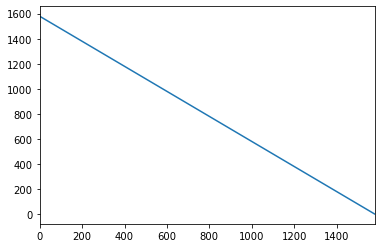

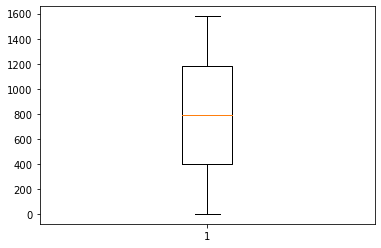

------------------------------------------------------------ Fecha de diagnóstico


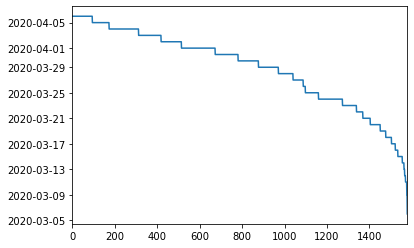

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

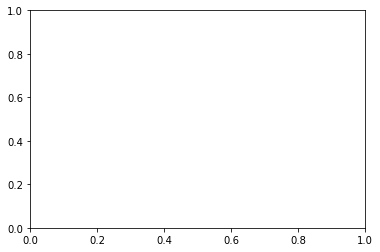

In [23]:
# analisis estadistico 
ETL(archivo)

Se puede hacer un modelo que nos diga la probabilidad de que un paciente en casa se recupere, vaya a UCI o fallezca

In [24]:
# filtrar los pacientes en casa y hospitales no UCI

pacientes2test = archivo[(archivo.Estado =='Casa') | (archivo.Estado =='Hospital')]
pacientes2test.head()

,ID,Fecha de diagnóstico,Ciudad_destino,Estado,Edad,Tipo,Pais_origen
5,6,2020-03-11,itagui,Casa,27,Relacionado,colombia
10,11,2020-03-12,bogota,Casa,42,Importado,espana
11,12,2020-03-12,neiva,Casa,74,Importado,italia
12,13,2020-03-12,neiva,Casa,68,Relacionado,colombia
17,18,2020-03-14,bogota,Casa,54,Importado,espana


In [25]:
data2model = archivo[(archivo.Estado !='Casa') & (archivo.Estado !='Hospital')]
data2model.Estado = data2model.Estado.replace(' ','-',regex=True).astype(str)
data2model.Estado.unique()

array(['Recuperado', 'Hospital-UCI', 'Fallecido'], dtype=object)

## Normalizando la data

In [26]:
data2model_normalizado =  normalizando_la_data(data2model)
data2model_normalizado.head()

,ID,Fecha de diagnóstico,Estado,Ciudad_destino_armenia,Ciudad_destino_barrancabermeja,Ciudad_destino_barranquilla,Ciudad_destino_bello,Ciudad_destino_bogota,Ciudad_destino_buga,Ciudad_destino_cajica,...,Pais_origen_italia,Pais_origen_jamaica,Pais_origen_londres,Pais_origen_mexico,Pais_origen_panama,Pais_origen_peru,Pais_origen_puertorico,Pais_origen_turquia,Pais_origen_venezuela,Edad
0,1,2020-03-06,Recuperado,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,-1.727129
1,2,2020-03-09,Recuperado,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.930693
2,3,2020-03-09,Recuperado,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.081161
3,4,2020-03-11,Recuperado,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.184318
4,5,2020-03-11,Recuperado,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.408554


### Analisis de correlación 

In [27]:
correlacion(data2model_normalizado)

# Construyendo el modelo

Se entrenarán un Random Forest y una regresión logística

In [28]:
# replace with 0 nan values
data2model_normalizado = data2model_normalizado.fillna(0)

In [29]:
# Borrando la columna del id del paciente
df_telcom_og = data2model_normalizado.copy()

In [33]:
#splitting train and test data # 15 for test and 85 for train
train,test = train_test_split(data2model_normalizado,test_size = .15 ,random_state = 123)

Id_user   = ['ID']
#Target columns
target_col   = ["Estado"]

#date
user_date = ['Fecha de diagnóstico']
    
##seperating dependent and independent variables
cols    = [i for i in data2model_normalizado.columns if i not in Id_user + target_col + user_date]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

In [55]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'scale'],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [56]:
svm_model = GridSearchCV(svm.SVC(), params_grid, cv=5)
svm_model.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001, 'scale'],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [57]:
print('Best score for training data:', (svm_model.best_score_)*100,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")


Best score for training data: 59.55056179775281 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [59]:
final_svm = svm_model.best_estimator_

# predict the labels on validation dataset
predictions_SVM = final_svm.predict(test_X)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, test_Y)*100)

SVM Accuracy Score ->  53.125


#### se normaliza la data a testear 

In [ ]:
data_totest_normalizado = normalizando_la_data(data_totest_def)

In [ ]:
correlacion(data_totest_normalizado)

In [ ]:
print(len(Vista_unica_modelo_normalizado.dtypes), len(data_totest_normalizado.dtypes))

In [ ]:
# replace with 0 nan values
data_totest_normalizado = data_totest_normalizado.fillna(0)

#### Prediciendo para la data no observada

In [ ]:
# Para fines practicos se borra la columna del id del cliente
data_totest_normalizado = data_totest_normalizado.drop(columns=['CEDULA1'], axis=1)

In [ ]:
##seperating dependent and independent variables

test_X_test  = data_totest_normalizado[cols]

probabilities  = logit.predict_proba(test_X_test) # probabilidad en 100%

print("la prediccion de no cancelacion es:",probabilities[:,0])
print("la prediccion de cancelacion es es:",probabilities[:,1])

prob_cancelacion = probabilities[:,1]

#creando la estrutura del archivo de salida
df_cancelados = pd.DataFrame(data=prob_cancelacion, index = data_totest_def.index, columns=['Prob'])
df_cancelados['Email'] = 'xibeline@gmail.com'
df_cancelados['NUMEROTARJETA1'] = data_totest_def['NUMEROTARJETA1'].astype(int)

In [ ]:
# se define la estructura del archivo respuesta
column_names = ["Email", "NUMEROTARJETA1", "Prob"]
df_cancelados = df_cancelados.reindex(columns=column_names)

Se guarda la información de las posibles cancelaciones

In [ ]:
file_name_xlsx = 'Resultados.xlsx'

df_cancelados.to_excel(os.path.join(dir_output,file_name_xlsx),sheet_name='Resultados')
              

In [ ]:
len(df_cancelados)

In [ ]:
len(data_totest_def)

In [ ]:
df_cancelados[df_cancelados['Prob'] == max(df_cancelados['Prob'])]

In [ ]:
max(df_cancelados['NUMEROTARJETA1'])